In [46]:
!ls predictions.json

predictions.json


In [47]:
with open('predictions.json') as file:
    p = file.read()
    
import jsonpickle
p = jsonpickle.decode(p)
p.shape

(75281, 6)

In [48]:
import pandas as pd
import numpy as np
DATA_DIR = './'

def read_trainset(filename=DATA_DIR+"stage_2_train.csv"):
    df = pd.read_csv(filename)
    df["Image"] = df["ID"].str.slice(stop=12)
    df["Diagnosis"] = df["ID"].str.slice(start=13)
    
    duplicates_to_remove = [
        56346,56347,56348,56349,
        56350,56351,1171830,1171831,
        1171832,1171833,1171834,1171835,
        3705312,3705313,3705314,3705315,
        3705316,3705317,3842478,3842479,
        3842480,3842481,3842482,3842483
    ]
    
    df = df.drop(index=duplicates_to_remove)
    df = df.reset_index(drop=True)
    
    df = df.loc[:, ["Label", "Diagnosis", "Image"]]
    df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
    
    return df

In [49]:
df = read_trainset()

In [50]:
ilosc = df.sum(axis=0).values[1:]

In [51]:
ilosc

array([ 3145, 36118, 26205, 35675, 47166])

In [52]:
label_names = df['Label'].keys().to_numpy()
label_names

array(['any', 'epidural', 'intraparenchymal', 'intraventricular',
       'subarachnoid', 'subdural'], dtype=object)

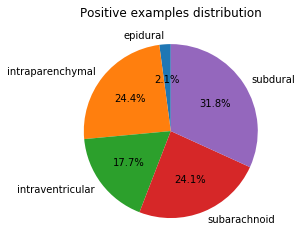

In [53]:
import matplotlib.pyplot as plt
#plt.figure(figsize=(7,7))
plt.title('Positive examples distribution')

handles = []
#for i, lab in enumerate(label_names):

plt.pie(ilosc, startangle=90, labels=label_names[1:], autopct='%1.1f%%')
#plt.legend(patches, label_names[1:], loc="best", bbox_to_anchor=(1, 0.5))

plt.show()

In [54]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df,test_size=0.1, random_state=257)

In [55]:
truth = test_df.to_numpy()
p=p[:len(truth)]

# AUC

In [56]:
auc = sklearn.metrics.roc_auc_score(truth, p)
auc

0.985664466056832

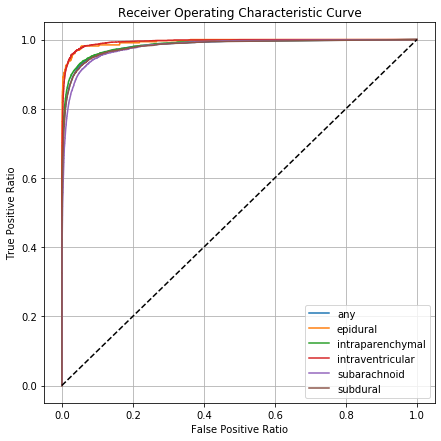

In [57]:
import sklearn
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.title('Receiver Operating Characteristic Curve')
plt.xlabel('False Positive Ratio')
plt.ylabel('True Positive Ratio')
plt.grid('major')

handles = []
for i, lab in enumerate(label_names):
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(truth[:,i], p[0:len(truth),i], drop_intermediate = True)
    ax = plt.plot(fpr,tpr)
    handles.append(ax)
    
plt.plot([0,1],[0,1], '--', color='black')
    
plt.legend(label_names)

In [58]:
precision, recall, pr_thresholds = sklearn.metrics.precision_recall_curve(truth[:,0], p[0:len(truth),0])

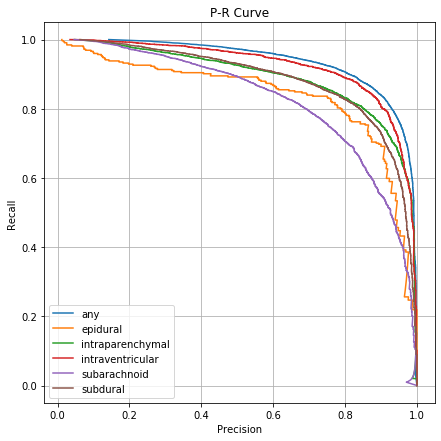

In [59]:
plt.figure(figsize=(7,7))
plt.title('P-R Curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid('major')

handles = []
for i, lab in enumerate(label_names):
    precision, recall, pr_thresholds = sklearn.metrics.precision_recall_curve(truth[:,i], p[0:len(truth),i])
    ax = plt.plot(precision, recall)
    handles.append(ax)

plt.legend(label_names)

In [60]:
precisions, recalls, pr_thresholds = {}, {}, {}
for i, lab in enumerate(label_names):
    prec, rec, pr_thr = sklearn.metrics.precision_recall_curve(truth[:,i], p[0:len(truth),i])
    precisions[lab] = prec
    recalls[lab] = rec
    pr_thresholds[lab] = pr_thr

In [61]:
len(pr_thresholds['any'])

22416

In [62]:
len(recalls['any'])

22417

In [63]:
a = round(pr_thresholds['any'][6672], 3)

In [64]:
(p[:, 0] > 0.1).shape

(75281,)

In [65]:
for prec in np.linspace(0.5,0.95,10):
    idx = np.argmin(np.abs(precisions['any'] - prec))
    pr = round(precisions['any'][idx],3)
    rc = round(recalls['any'][idx],3)
    thr = np.round(pr_thresholds['any'][idx], 3)
    acc = round(sklearn.metrics.accuracy_score(truth[:,0], p[:, 0] > thr), 3)
    print(f'{str(thr)} & {pr} & {rc} & {str(acc)} \\' +'\\') 

0.0 & 0.5 & 0.973 & 0.595 \\
0.001 & 0.55 & 0.966 & 0.89 \\
0.002 & 0.6 & 0.959 & 0.906 \\
0.004 & 0.65 & 0.95 & 0.921 \\
0.008 & 0.7 & 0.939 & 0.934 \\
0.018 & 0.75 & 0.925 & 0.945 \\
0.045 & 0.8 & 0.906 & 0.954 \\
0.122 & 0.85 & 0.877 & 0.96 \\
0.345 & 0.9 & 0.839 & 0.964 \\
0.828 & 0.95 & 0.763 & 0.961 \\


In [66]:
r = np.zeros((6,4))
for i, lab in enumerate(label_names):
    idx = np.argmin(np.abs(precisions[lab] - 0.7))
    pr = round(precisions[lab][idx],2)
    rc = round(recalls[lab][idx],3)
    thr = np.round(pr_thresholds[lab][idx], 3)
    acc = round(sklearn.metrics.accuracy_score(truth[:,i], p[:, i] > thr), 3)
    r[i][0] = pr
    r[i][1] = thr
    r[i][2] = rc
    r[i][3] = acc
    print(f'{lab[:6]}. & {pr} & {str(thr)} & {rc} & {acc} \\' +'\\') 

any. & 0.7 & 0.008 & 0.939 & 0.934 \\
epidur. & 0.7 & 0.105 & 0.84 & 0.998 \\
intrap. & 0.7 & 0.035 & 0.879 & 0.976 \\
intrav. & 0.7 & 0.088 & 0.922 & 0.984 \\
subara. & 0.7 & 0.125 & 0.794 & 0.975 \\
subdur. & 0.7 & 0.034 & 0.875 & 0.969 \\


In [67]:
np.sum(df['Label']['any'] == 0)/len(df)

0.856625172853987

In [68]:
np.sum(df['Label']['any'] == 1)/len(df)

0.14337482714601296

In [69]:
np.sum(np.sum(df['Label'],axis=1) > 2)/len(df)

0.0426061001350951

In [70]:
len(df)

752803

In [75]:
for row in r.transpose():
    for el in row:
        print(f'{round(el,3)} & ', end='') 
    print('\\' +'\\')

0.7 & 0.7 & 0.7 & 0.7 & 0.7 & 0.7 & \\
0.008 & 0.105 & 0.035 & 0.088 & 0.125 & 0.034 & \\
0.939 & 0.84 & 0.879 & 0.922 & 0.794 & 0.875 & \\
0.934 & 0.998 & 0.976 & 0.984 & 0.975 & 0.969 & \\
